In [1]:
import kagglehub
michaelfumery_unlabeled_stanford_dags_dataset_path = kagglehub.dataset_download('michaelfumery/unlabeled-stanford-dags-dataset')

print('Data source import complete.')
print(michaelfumery_unlabeled_stanford_dags_dataset_path)


Data source import complete.
/root/.cache/kagglehub/datasets/michaelfumery/unlabeled-stanford-dags-dataset/versions/3


In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import random
from PIL import Image
import torch



In [3]:
dataset_path = "/root/.cache/kagglehub/datasets/michaelfumery/unlabeled-stanford-dags-dataset/versions/3/Unlabeled_Stanford_Dogs_Dataset"
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")

In [4]:
def load_image(folder_path):
    image_paths = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_paths.append(os.path.join(root, file))
    return image_paths

train_images = load_image(train_path)
test_images = load_image(test_path)

In [5]:
print(f"Number of training images: {len(train_images)}")
print(f"Number of testing images: {len(test_images)}")

Number of training images: 1759
Number of testing images: 763


In [6]:
def read_image(folder_path):
    image_paths = []
    images = []

    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(('.jpg')):
                image_path = os.path.join(root, file)
                image_paths.append(image_path)

                img = Image.open(image_path)
                images.append(img)

    return image_paths, images

In [7]:
train_images_paths, train_images_data = read_image(train_path)
test_images_paths, test_images_data = read_image(test_path)


images_shape = np.array(train_images_data[0]).shape
print(f"Shape of the first training image: {images_shape}")
print(f"Shape of the first testing image: {np.array(test_images_data[0]).shape}")

Shape of the first training image: (500, 333, 3)
Shape of the first testing image: (334, 500, 3)


In [8]:
def plot_images(image_paths, num_images=5):
  random_paths = random.sample(image_paths, min(num_images, len(image_paths)))

  fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
  for i, path in enumerate(random_paths):
    image = Image.open(path)
    axes[i].imshow(image)
    axes[i].axis('off')
  plt.show()

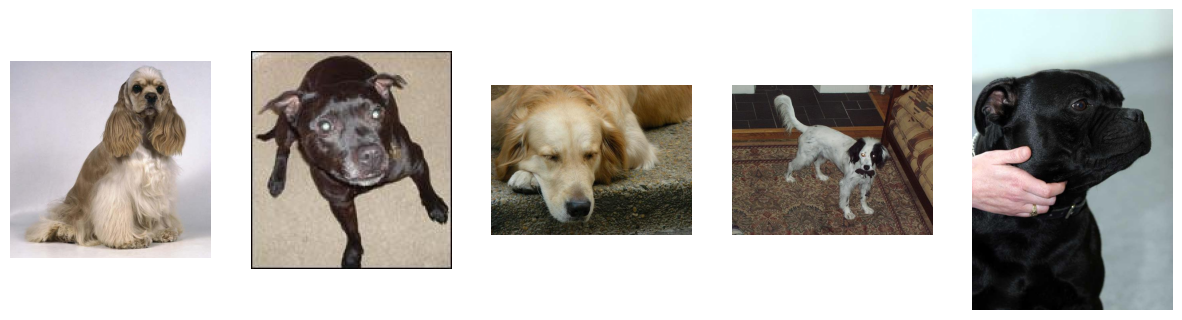

In [9]:
plot_images(train_images)

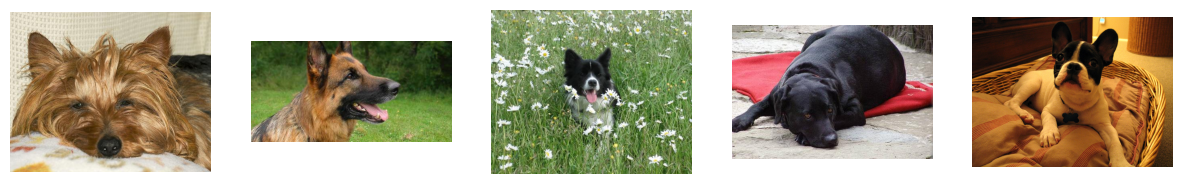

In [10]:
plot_images(test_images)

In [11]:
target_size = (32, 32)

transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.229, 0.224, 0.225]),
])

In [12]:
def apply_transform(image_paths, transform):
    transformed_images = []

    for image_path in image_paths:
        with Image.open(image_path) as img:
            transformed_img = transform(img)
            transformed_images.append(transformed_img)

    return transformed_images


train_transformed_images = apply_transform(train_images, transform)
test_transformed_images = apply_transform(test_images, transform)

print(f"Shape of the first transformed training image: {train_transformed_images[0].shape}")
print(f"Shape of the first transformed testing image: {test_transformed_images[0].shape}")

Shape of the first transformed training image: torch.Size([3, 32, 32])
Shape of the first transformed testing image: torch.Size([3, 32, 32])


In [13]:
train_transformed_images=train_transformed_images[:250]
test_transformed_images=test_transformed_images[:250]

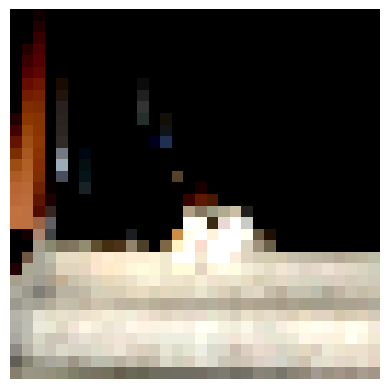

In [14]:
plt.imshow(train_transformed_images[0].permute(1, 2, 0))
plt.axis('off')
plt.show()

# Convert images to Feature Vector

In [15]:
def flatten_image(image_tensor):
    flatten = image_tensor.view(-1)
    return flatten

In [16]:
train_flattened_images = [flatten_image(img) for img in train_transformed_images]
test_flattened_images = [flatten_image(img) for img in test_transformed_images]

print(f"Shape of the first flattened training image: {train_flattened_images[0].shape}")
print(f"Shape of the first flattened testing image: {test_flattened_images[0].shape}")

Shape of the first flattened training image: torch.Size([3072])
Shape of the first flattened testing image: torch.Size([3072])


# Calc Mean, Shifted FV & Covariance matrix

In [17]:
def mean_centered(flattened_images):
    flattened_arr = np.array([img.numpy() for img in flattened_images])
    mean = np.mean(flattened_arr, axis=0)
    shifted_fv = flattened_arr - mean
    return shifted_fv, mean

In [18]:
def calc_cov_matrix(mean_centered):
    cov_matrix = np.cov(mean_centered, rowvar=False)
    return cov_matrix

In [19]:
def remove_constant_columns(flattened_images):
    try:
        data_array = np.array(flattened_images)
    except ValueError as e:
        print(f"Error converting to numpy array: {e}")
        return None, None

    constant_columns = []
    num_cols = data_array.shape[1]
    i = 0
    while i < num_cols:
        if np.all(data_array[:, i] == data_array[0, i]):
            print(f"Column {i} is constant!")
            constant_columns.append(i)
            data_array = np.delete(data_array, i, axis=1)
            num_cols = data_array.shape[1]
            i -=1
        i += 1
    return data_array, constant_columns

In [20]:
train_fv_array, train_constant_cols = remove_constant_columns(train_flattened_images)

if train_fv_array is not None:
    train_fv, train_mean = mean_centered(train_flattened_images)
    train_cov_matrix = calc_cov_matrix(train_fv)
    print(f"Shape of Training Covariance Matrix after removing constant columns: {train_cov_matrix.shape}")
else:
    print("Error processing training data")

Shape of Training Covariance Matrix after removing constant columns: (3072, 3072)


In [21]:
test_fv_array, test_constant_cols = remove_constant_columns(test_flattened_images)
if test_fv_array is not None:
    test_fv, test_mean = mean_centered(test_flattened_images)
    test_cov_matrix = calc_cov_matrix(test_fv)
    print(f"Shape of Testing Covariance Matrix after removing constant columns: {test_cov_matrix.shape}")
else:
    print("Error processing testing data")

Shape of Testing Covariance Matrix after removing constant columns: (3072, 3072)


# Calc Eigenvalues & Eigenvector

In [22]:
def power_iteration(A, num_iterations=100):
    n = A.shape[0]
    V = np.random.rand(n)
    last_eigenvalue = 0

    for _ in range(num_iterations):
        AV = A @ V
        eigenvalue = np.linalg.norm(AV)

        if eigenvalue == 0:
            return 0, np.random.rand(n)

        V = AV / eigenvalue

        last_eigenvalue = eigenvalue

    return eigenvalue, V


In [23]:
def deflate_matrix(A, eigenvalue, eigenvector):
    n = A.shape[0]
    outer_product = np.outer(eigenvector, eigenvector)
    return A - eigenvalue * outer_product

In [24]:
def calculate_eigenvalues_eigenvectors(covariance_matrix, num_iterations=100):
    n = covariance_matrix.shape[0]
    eigenvalues = []
    eigenvectors = []
    A = covariance_matrix.copy()

    for _ in range(n):
        eigenvalue, eigenvector = power_iteration(A, num_iterations)
        eigenvalues.append(eigenvalue)
        eigenvectors.append(eigenvector)
        A = deflate_matrix(A, eigenvalue, eigenvector)

    return np.array(eigenvalues), np.array(eigenvectors).T

In [25]:
def select_eigenvectors(eigenvalues, eigenvectors, k):
    sorted_index = np.argsort(eigenvalues)[::-1]
    top_k_eigenvectors = eigenvectors[:, sorted_index[:k]]

    return top_k_eigenvectors

In [26]:
def calculate_reconstruction_error(original_data, reconstructed_data):
    return np.mean((original_data - reconstructed_data)**2)

# Selecting the Best Q Matrix (k)

In [27]:
train_eigenvalues, train_eigenvectors = calculate_eigenvalues_eigenvectors(train_cov_matrix)
k_values = [10, 20, 50, 100, 200]
explained_variance_ratios = []
reconstruction_errors = []

In [28]:
def unnormalize(tensor, mean, std):
    """Unnormalizes a tensor image with mean and standard deviation."""
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [29]:
def visualize_reconstruction(original_images, reconstructed_images, k, num_to_visualize=5):
    """Visualizes original and reconstructed images with k value."""
    indices = np.random.choice(len(original_images), num_to_visualize, replace=False)

    fig, axes = plt.subplots(2, num_to_visualize, figsize=(15, 6))
    fig.suptitle(f"Reconstruction with k = {k}", fontsize=16)

    mean = torch.tensor([0.5, 0.5, 0.5])
    std = torch.tensor([0.229, 0.224, 0.225])

    for i, idx in enumerate(indices):

        original_img = original_images[idx].reshape(3, target_size[0], target_size[1]).permute(1, 2, 0)
        reconstructed_img = reconstructed_images[idx].reshape(3, target_size[0], target_size[1]).permute(1, 2, 0)


        original_img = unnormalize(original_img, mean, std)
        reconstructed_img = unnormalize(reconstructed_img, mean, std)


        original_img = torch.clamp(original_img, 0, 1)
        reconstructed_img = torch.clamp(reconstructed_img, 0, 1)

        axes[0, i].imshow(original_img)
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(reconstructed_img)
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

k = 10, Reconstruction Error: 17.2848


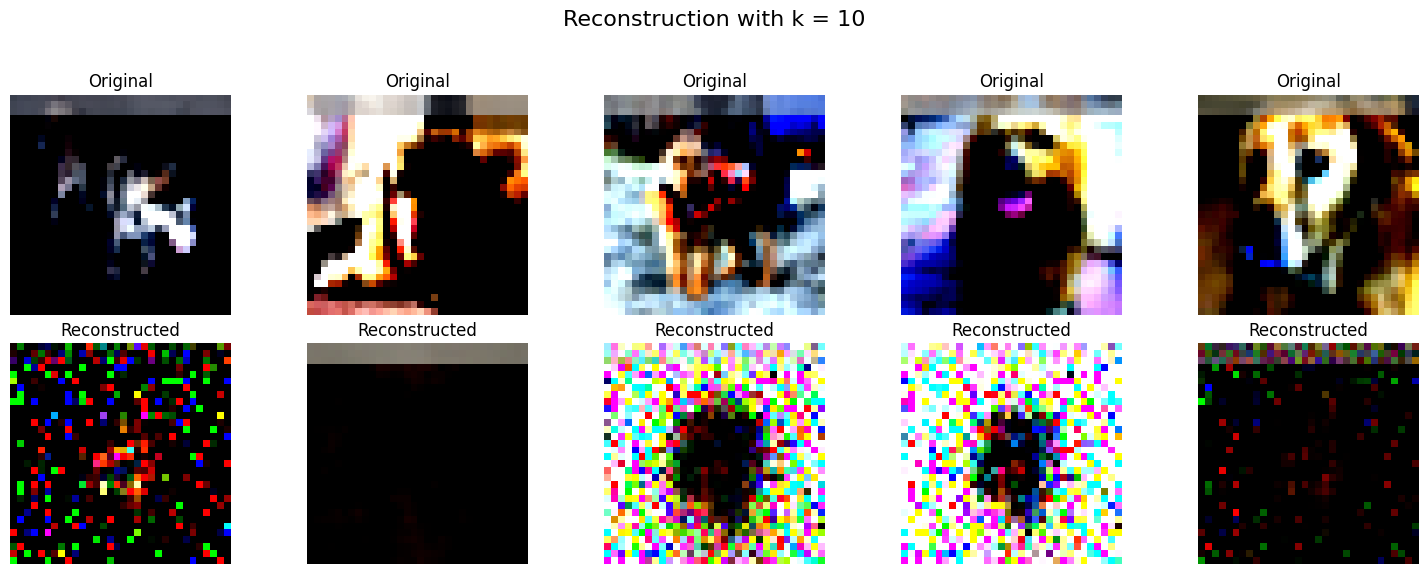

k = 20, Reconstruction Error: 73.2592


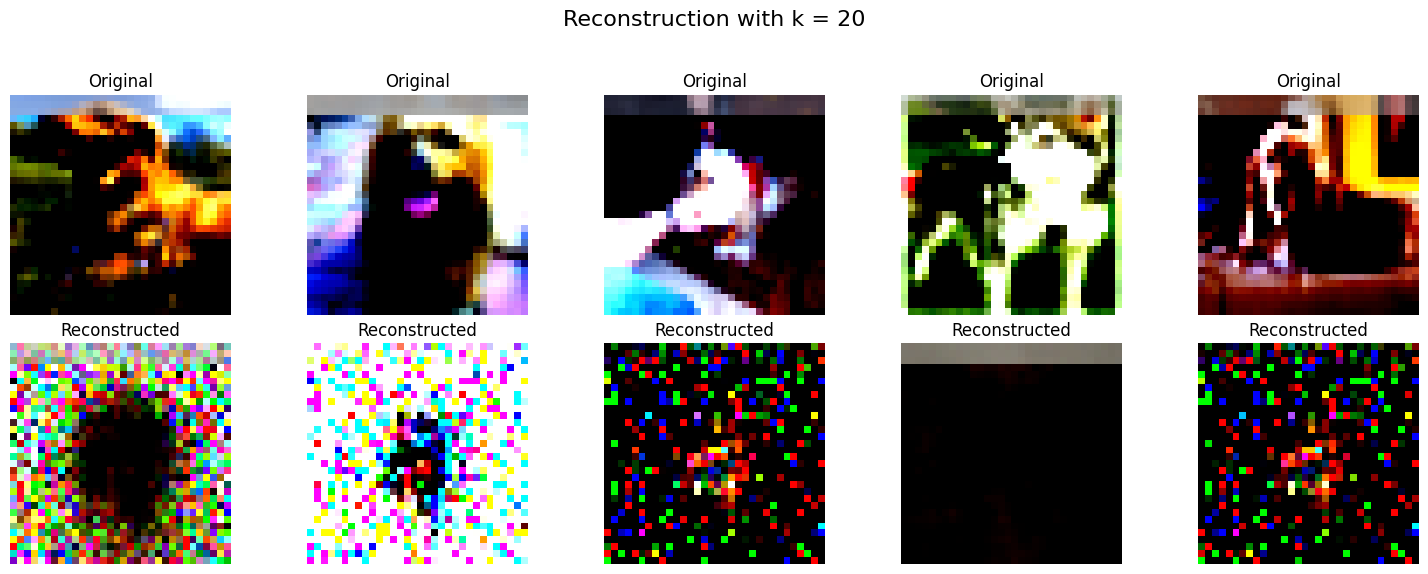

k = 50, Reconstruction Error: 480.2849


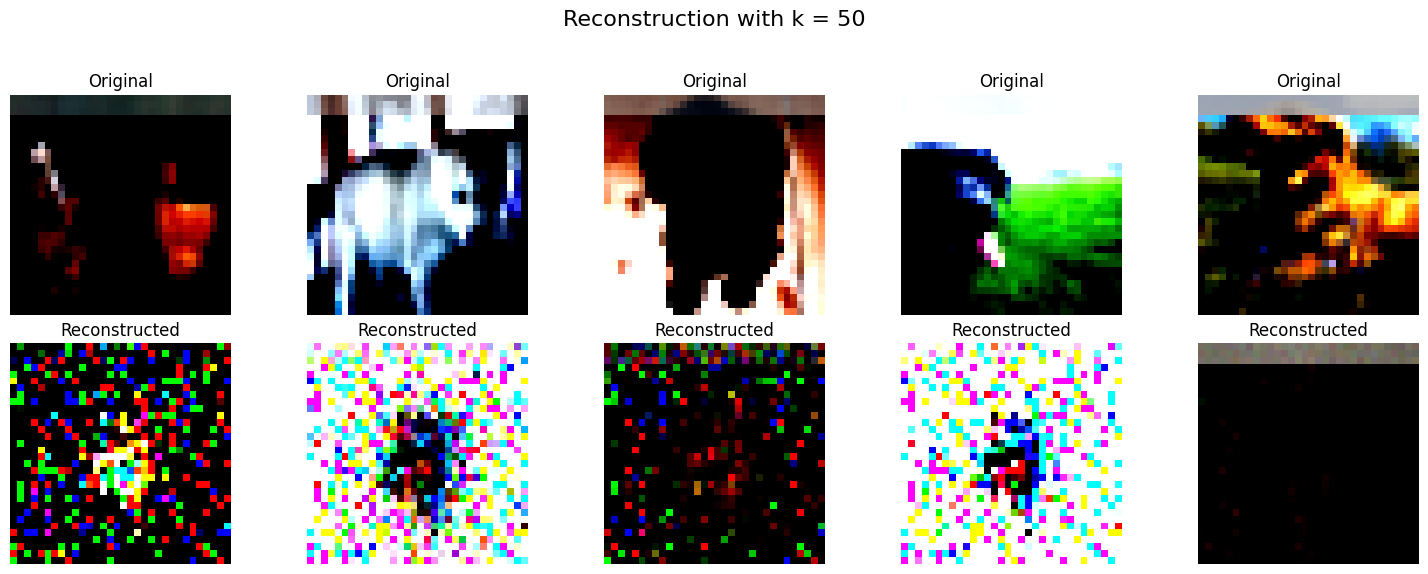

k = 100, Reconstruction Error: 1946.4336


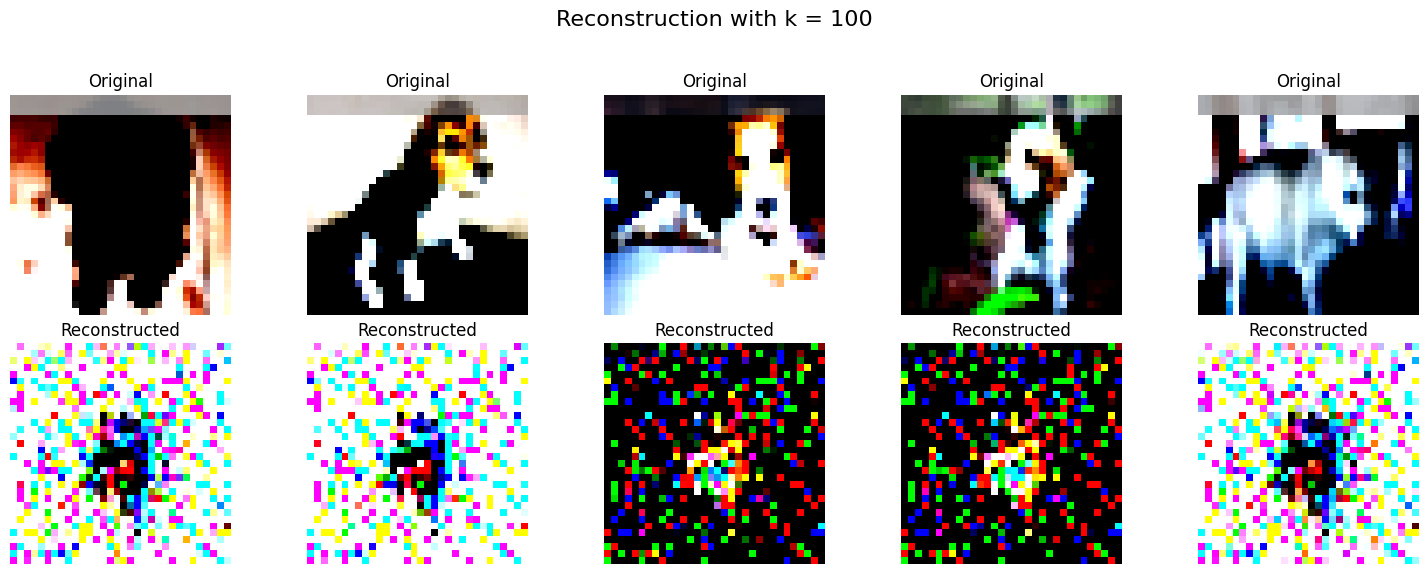

k = 200, Reconstruction Error: 7851.8933


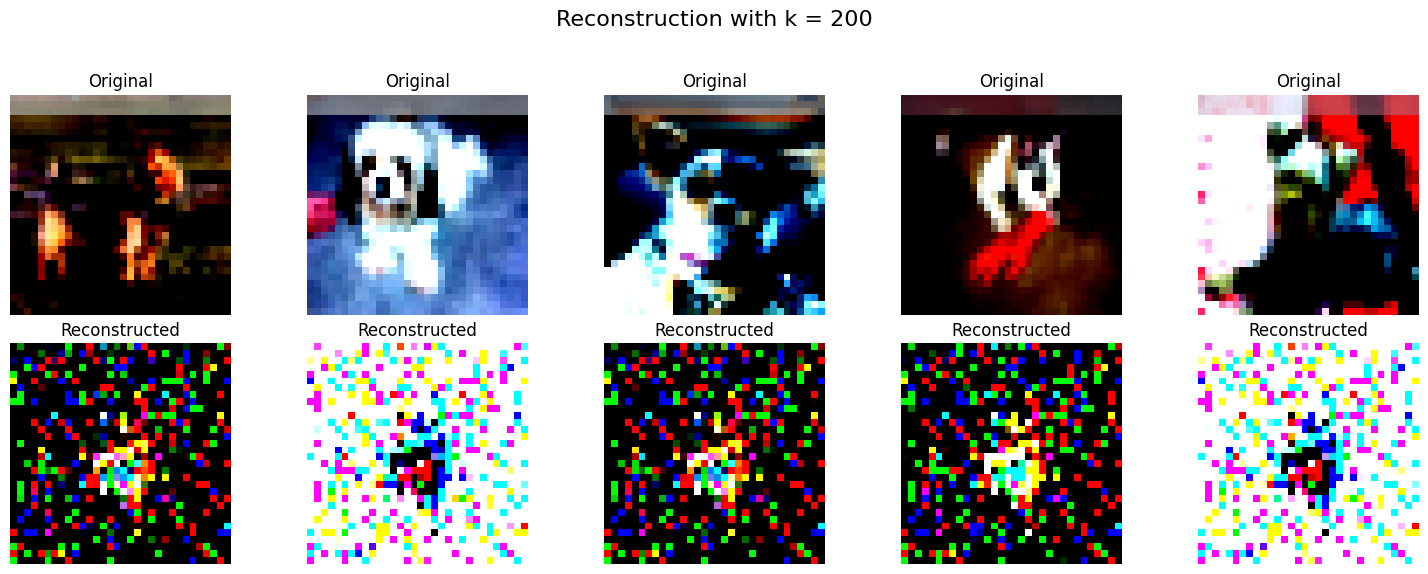

In [30]:
explained_variance_ratios = []
reconstruction_errors = []

for k in k_values:
    top_k_eigenvectors = select_eigenvectors(train_eigenvalues, train_eigenvectors, k)
    explained_variance_ratio = np.sum(train_eigenvalues[:k]) / np.sum(train_eigenvalues)
    explained_variance_ratios.append(explained_variance_ratio)
    reduced_data = train_fv.dot(top_k_eigenvectors)
    reconstructed_data = reduced_data.dot(top_k_eigenvectors.T) + train_mean
    reconstruction_error = calculate_reconstruction_error(train_fv, reconstructed_data)
    reconstruction_errors.append(reconstruction_error)
    print(f"k = {k}, Reconstruction Error: {reconstruction_error:.4f}")


    train_flattened_images_tensor = [torch.from_numpy(arr).float() for arr in train_fv]
    reconstructed_data_tensor = [torch.from_numpy(arr).float() for arr in reconstructed_data]
    visualize_reconstruction(train_flattened_images_tensor, reconstructed_data_tensor, k)

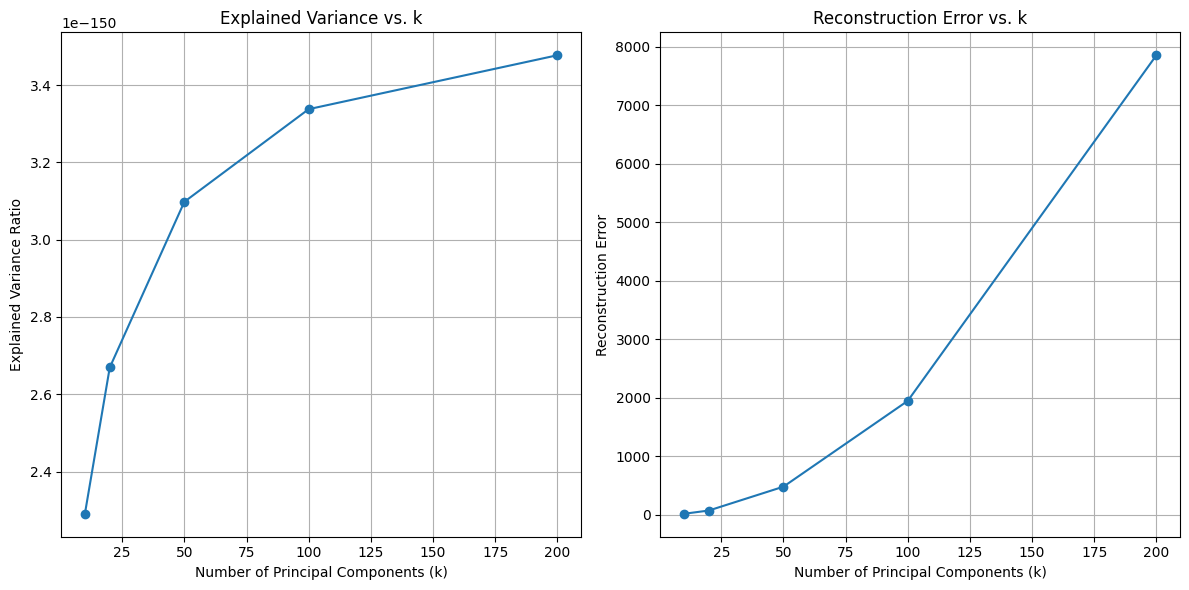

The best k is: 10
The lowest reconstruction error is: 17.2848


In [31]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, explained_variance_ratios, marker='o')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance vs. k")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, reconstruction_errors, marker='o')
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction Error vs. k")
plt.grid(True)

plt.tight_layout()
plt.show()

best_k = k_values[np.argmin(reconstruction_errors)]
print(f"The best k is: {best_k}")
lowest_reconstruction_error = np.min(reconstruction_errors)
print(f"The lowest reconstruction error is: {lowest_reconstruction_error:.4f}")

In [33]:
for i in range (len(k_values)):
    print(f"k = {k_values[i]}, Reconstruction Error: {reconstruction_errors[i]:.4f}")


k = 10, Reconstruction Error: 17.2848
k = 20, Reconstruction Error: 73.2592
k = 50, Reconstruction Error: 480.2849
k = 100, Reconstruction Error: 1946.4336
k = 200, Reconstruction Error: 7851.8933
